# Exploratory Data Analysis (EDA) #

In [18]:
import numpy as np
import os

# Load the data from the .npy file
data_path = 'data/ai_ready'
file_name = '1_ready.npy'
full_path = os.path.join(data_path, file_name)
east_component_data = np.load(full_path)

# Define a window size and overlap (in number of samples)
window_size = 1000  # e.g., 10 seconds
overlap = 500

# Sliding window function
def sliding_window(data, window_size, overlap):
    step = window_size - overlap
    windows = [data[i:i+window_size] for i in range(0, len(data)-window_size+1, step)]
    return windows

# Apply the sliding window function to the data
windows = sliding_window(east_component_data, window_size, overlap)

# Feature extraction: calculate mean, std, etc. for each window
features = []
for window in windows:
    mean = np.mean(window)
    std = np.std(window)
    max_val = np.max(window)
    min_val = np.min(window)
    features.append([mean, std, max_val, min_val])

# Convert the features list to a NumPy array
features = np.array(features)

# Print the shape of the features array to verify
print('Features shape:', features.shape, '\n')

# Print the first few rows of the features array
print('First 5 rows of features:')
print(features[:5], '\n')

# Print summary statistics for each feature
feature_names = ['Mean', 'Std', 'Max', 'Min']
for i, name in enumerate(feature_names):
    print(f'{name} - Mean: {np.mean(features[:, i]):.2f}, Std: {np.std(features[:, i]):.2f}, '
          f'Min: {np.min(features[:, i]):.2f}, Max: {np.max(features[:, i]):.2f}')

# Print the data types of the features
print('Data types of features:', features.dtype)

# Optionally, save the features to a new .npy file
output_file = os.path.join(data_path, '1_ready_features.npy')
#os.makedirs(data_path, exist_ok=True)
np.save(output_file, features)


Features shape: (4319, 4) 

First 5 rows of features:
[[-109.34955009  212.82859955  383.24997948 -692.68329464]
 [-164.61043842  258.39848484  418.46671248 -861.49632894]
 [ -31.04403781  291.21056358  602.19007292 -861.49632894]
 [  74.81994541  239.63675728  657.65419763 -450.81661497]
 [ -23.52964887  298.96738759  657.65419763 -772.65184482]] 

Mean - Mean: 8.80, Std: 92.40, Min: -297.73, Max: 230.62
Std - Mean: 168.87, Std: 60.38, Min: 68.96, Max: 956.24
Max - Mean: 445.49, Std: 178.45, Min: 47.71, Max: 2005.59
Min - Mean: -424.70, Std: 194.87, Min: -2162.57, Max: -17.73
Data types of features: float64


## Apply PCA on the selected features ##

Explained variance ratio: [0.5789499  0.37384033]


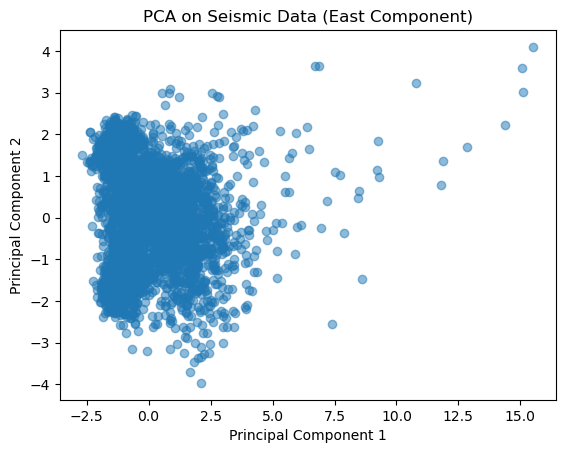

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
features_pca = pca.fit_transform(features_scaled)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

# Visualize the results

plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha = 0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Seismic Data (East Component)')
plt.show()

## Frequency domain representation ##

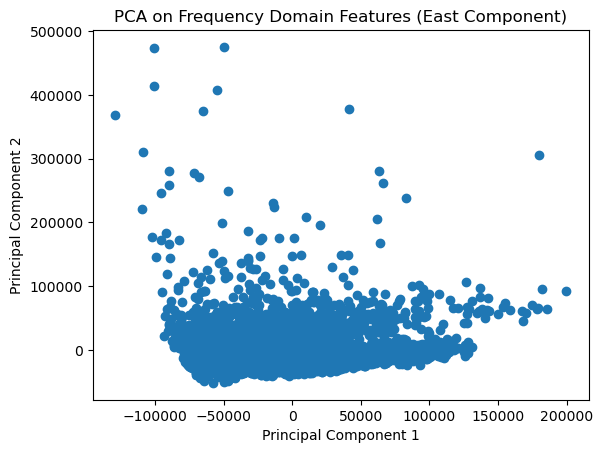

In [20]:
from scipy.fft import fft

# Apply Fourier Transform on each window
fft_features = [np.abs(fft(window))[:len(window)//2] for window in windows]

# Apply PCA on frequency features
fft_features = np.array(fft_features)
pca = PCA(n_components=2)
fft_pca = pca.fit_transform(fft_features)

# Plot the results
plt.scatter(fft_pca[:, 0], fft_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Frequency Domain Features (East Component)')
plt.show()




### Task ###
Perform a basic exploration of the cleaned data to understand its structure and key characteristics.

### Requirements ###

This notebook will include:
- Basic summary statistics of the dataset (mean, variance, min, max, etc.).
- Visualization of feature distributions (histograms, box plots, etc.).
- Correlation analysis between different features and target variables (correlation matrix, heatmaps).
- Brief discussion on any patterns or insights observed during the analysis.
